In [0]:
!pip install cmake 'gym[atari]' scipy

#Initializing our environment

In [0]:
import gym

env = gym.make("Taxi-v2").env
env.render() # doing a quick render

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [0]:
help(env)

Help on TaxiEnv in module gym.envs.toy_text.taxi object:

class TaxiEnv(gym.envs.toy_text.discrete.DiscreteEnv)
 |  The Taxi Problem
 |  from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
 |  by Tom Dietterich
 |  
 |  Description:
 |  There are four designated locations in the grid world indicated by R(ed), B(lue), G(reen), and Y(ellow). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drive to the passenger's location, pick up the passenger, drive to the passenger's destination (another one of the four specified locations), and then drop off the passenger. Once the passenger is dropped off, the episode ends.
 |  
 |  Observations: 
 |  There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is the taxi), and 4 destination locations. 
 |  
 |  Actions: 
 |  There are 6 discrete deterministic actions:

#Here's how we reset our environment randomly and render it

In [0]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



- __env.action_space__ returns total number of decisions we can make in order to take an action in our environment
- __env.observation_space__ return total number of possible states

In [0]:
print(f"Action Space: {env.action_space}")
print(f"State Space: {env.observation_space}")

Action Space: Discrete(6)
State Space: Discrete(500)


#Here's how we can take an action and render the envirenment

In [0]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)
env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



#Below is our reward table for given state
Structure is for {action: (probability, nextstate, reward, done)}
- (probability, nextstate, reward, done) provides information about what would happen in the future state if we take this action.
- probability is always 1.
- The nextstate is the state we would be in if we take this action.
- All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state.
- The reward for right action is +20 at the dropoff action.
- Each successfull dropoff is the end of an episode

In [0]:
env.P[state]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

Here's how we can take a random action

In [0]:
env.action_space.sample()

4

#Taking random actions to reach destination

In [0]:
env.s = 328
epochs = 0
penalties, reward = 0, 0

frames = [] # for animation
done = False
while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 255
Penalties incurred: 57


In [0]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames, pause = 0.1):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'].getvalue())
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(pause)
        
print_frames(frames)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 255
State: 0
Action: 5
Reward: 20


So as we can see in above cell that choosing actions randomly is taking forever, so this method would'd work (obviously) .

#Time to use Q-Learning

##Initializing our Q table

In [0]:
import numpy as np

print(f'Observation space: {env.observation_space.n}')
print(f'Action space: {env.action_space.n}')
 
q_table = np.zeros([env.observation_space.n, env.action_space.n])
print(f'\nq_table shape:', q_table.shape)
print(q_table)

Observation space: 500
Action space: 6

q_table shape: (500, 6)
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


##Training the Q-Table

In [0]:
import matplotlib.pyplot as plt
import random

alpha = 0.75
gamma = 0.5
epsilon = 0.1
penalties = []
rewards = []

for i in range(100000):
    state = env.reset()

    epochs, penalty, reward, = 0, 0, 0
    done = False
    
    cum_reward = []
        
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Selecting random action for some exploration
        else:
            action = np.argmax(q_table[state]) # Selecting action from the Q table

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalty += 1

        state = next_state
        epochs += 1
        
        cum_reward.append(reward)
        
    if (i + 1) % 1000 == 0:
        clear_output(wait = True)
        print(f"Episode: {i + 1}")
    
    penalties.append(penalty / (len(penalties) + 1))
    rewards.append(sum(cum_reward)/len(cum_reward)) # appending mean of rewards for every episode

Episode: 100000


##Lets see our Q-Table

In [0]:
q_table

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -1.95703125,  -1.9140625 ,  -1.95703125,  -1.9140625 ,
         -1.828125  , -10.9140625 ],
       [ -1.828125  ,  -1.65625   ,  -1.828125  ,  -1.65625   ,
         -1.3125    , -10.65625   ],
       ...,
       [ -1.31438398,  -0.625     ,  -1.31417227,  -1.82375765,
        -10.26855652, -10.31130552],
       [ -1.95724297,  -1.92683784,  -1.95890029,  -1.9140625 ,
        -10.90301514, -10.7409668 ],
       [  3.5       ,   0.75      ,   3.5       ,   9.        ,
         -5.5       ,  -5.5       ]])

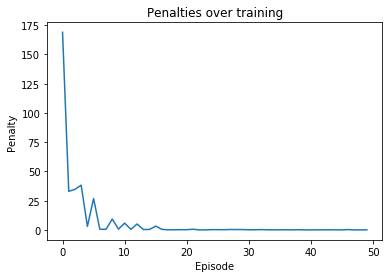

In [0]:
plt.plot(penalties[:50])
plt.title('Penalties over training')
plt.xlabel('Episode')
plt.ylabel('Penalty')
plt.show()

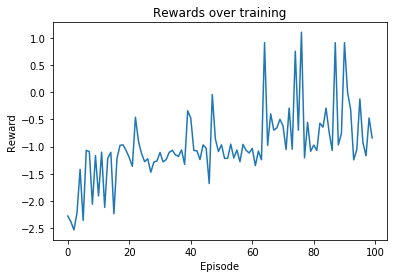

In [0]:
plt.plot(rewards[:100])
plt.title('Rewards over training')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

##Testing our trained Q-Table

In [0]:
env.s = 328
epochs = 0
penalties, reward = 0, 0

frames = [] # for animation
done = False

env.reset()
while not done:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 15
Penalties incurred: 0


In [0]:
print_frames(frames, 0.5)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 15
State: 410
Action: 5
Reward: 20
